# Reconstruction

Reference: https://tomroelandts.com/articles/astra-toolbox-tutorial-reconstruction-from-projection-images-part-2

In [2]:
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import imread, imwrite
import matplotlib.pyplot as plt
import astra
import h5py
import os
import mrcfile
from tvtk.api import tvtk
from mayavi import mlab
from IPython.display import Image
import sys
sys.path.append("../..") 
from cryoem.projections import RotationMatrix

# True Angles and Projections

In [2]:
INPUT_FILE = "5a1a_projections_and_angles"
OUTPUT_FILE = "5a1a_projections_and_angles"

## Create data for reconstruction (projections and angles pairs)

In [3]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# full coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber{NUM_PROJECTIONS}_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')
    
np.savez(f"data/{INPUT_FILE}", data['Projections'], data['Angles'])

## Reconstruction

In [4]:
data = np.load(f'data/{INPUT_FILE}.npz')
projections, angles = data["arr_0"].astype(np.float64)[:3000, :, :], data["arr_1"].astype(np.float64)[:3000, :]

# Generate orientation vectors based on angles
orientation_vectors   = RotationMatrix(angles)

# Reshape projections correctly 
projections1 = np.transpose(projections, (1, 0, 2))
# Get projection dimension
proj_size = projections1.shape[0]

# Create projection 2D geometry in ASTRA
proj_geom = astra.create_proj_geom('parallel3d_vec', proj_size, proj_size, orientation_vectors)
projections_id = astra.data3d.create('-sino', proj_geom, projections1)

# Create reconstruction.
vol_geom = astra.creators.create_vol_geom(proj_size, proj_size, proj_size)
reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
alg_cfg = astra.astra_dict('BP3D_CUDA')
alg_cfg['ProjectionDataId'] = projections_id
alg_cfg['ReconstructionDataId'] = reconstruction_id
algorithm_id = astra.algorithm.create(alg_cfg)
astra.algorithm.run(algorithm_id)
reconstruction = astra.data3d.get(reconstruction_id)


# Limit and scale reconstruction.
reconstruction[reconstruction < 0] = 0
reconstruction /= np.max(reconstruction)
reconstruction = np.round(reconstruction * 255).astype(np.uint8)
    
# Cleanup.
astra.algorithm.delete(algorithm_id)
astra.data3d.delete(reconstruction_id)
astra.data3d.delete(projections_id)

# Save reconstruction to mrc file for chimera
with mrcfile.new(f'data/{OUTPUT_FILE}.mrc') as mrc:
    mrc.set_data(reconstruction)

## Plot reconstruction result

In [5]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
#mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

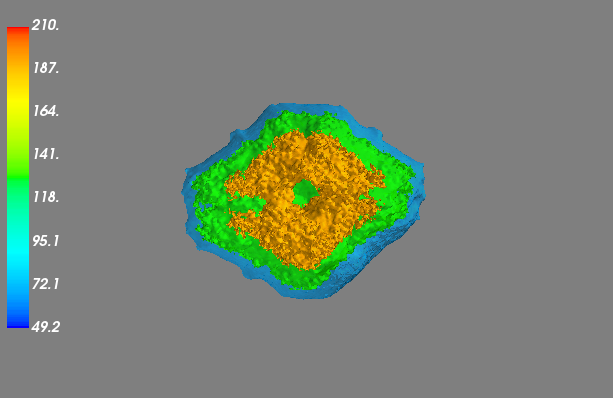

In [3]:
Image(filename='data/5a1a_projections_and_angles.png') 

---

# True Angles and Projections

In [6]:
INPUT_FILE = "5a1a_projections_and_angles_half"
OUTPUT_FILE = "5a1a_projections_and_angles_half"

## Create data for reconstruction (projections and angles pairs)

In [7]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber{NUM_PROJECTIONS}_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')
    
np.savez(f"data/{INPUT_FILE}", data['Projections'], data['Angles'])

## Reconstruction

In [8]:
data = np.load(f'data/{INPUT_FILE}.npz')
projections, angles = data["arr_0"].astype(np.float64)[:3000, :, :], data["arr_1"].astype(np.float64)[:3000, :]

# Generate orientation vectors based on angles
orientation_vectors   = RotationMatrix(angles)

# Reshape projections correctly 
projections1 = np.transpose(projections, (1, 0, 2))
# Get projection dimension
proj_size = projections1.shape[0]

# Create projection 2D geometry in ASTRA
proj_geom = astra.create_proj_geom('parallel3d_vec', proj_size, proj_size, orientation_vectors)
projections_id = astra.data3d.create('-sino', proj_geom, projections1)

# Create reconstruction.
vol_geom = astra.creators.create_vol_geom(proj_size, proj_size, proj_size)
reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
alg_cfg = astra.astra_dict('BP3D_CUDA')
alg_cfg['ProjectionDataId'] = projections_id
alg_cfg['ReconstructionDataId'] = reconstruction_id
algorithm_id = astra.algorithm.create(alg_cfg)
astra.algorithm.run(algorithm_id)
reconstruction = astra.data3d.get(reconstruction_id)


# Limit and scale reconstruction.
reconstruction[reconstruction < 0] = 0
reconstruction /= np.max(reconstruction)
reconstruction = np.round(reconstruction * 255).astype(np.uint8)
    
# Cleanup.
astra.algorithm.delete(algorithm_id)
astra.data3d.delete(reconstruction_id)
astra.data3d.delete(projections_id)

# Save reconstruction to mrc file for chimera
with mrcfile.new(f'data/{OUTPUT_FILE}.mrc') as mrc:
    mrc.set_data(reconstruction)

## Plot reconstruction result

In [9]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
#mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

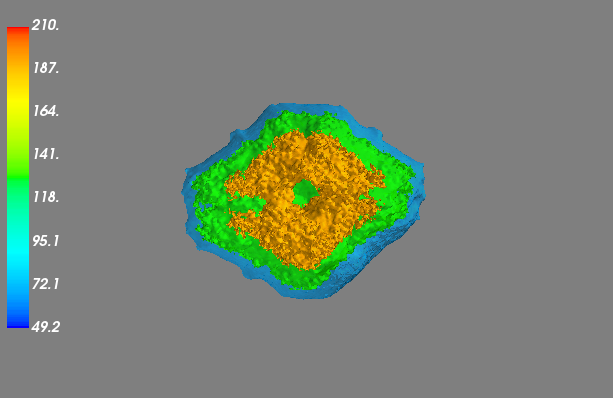

In [4]:
Image(filename='data/5a1a_projections_and_angles.png')

---

# Half-cover Predicted Angles and Projections

In [10]:
INPUT_FILE = "5a1a_projections_and_angles_predicted"
OUTPUT_FILE = "5a1a_projections_and_angles_predicted"

## Reconstruction

In [11]:
data = np.load(f'data/{INPUT_FILE}.npz')
projections, angles = data["arr_0"].astype(np.float64)[:3000, :, :], data["arr_1"].astype(np.float64)[:3000, :]

# Generate orientation vectors based on angles
orientation_vectors   = RotationMatrix(angles)

# Reshape projections correctly 
projections1 = np.transpose(projections, (1, 0, 2))
# Get projection dimension
proj_size = projections1.shape[0]

# Create projection 2D geometry in ASTRA
proj_geom = astra.create_proj_geom('parallel3d_vec', proj_size, proj_size, orientation_vectors)
projections_id = astra.data3d.create('-sino', proj_geom, projections1)

# Create reconstruction.
vol_geom = astra.creators.create_vol_geom(proj_size, proj_size, proj_size)
reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
alg_cfg = astra.astra_dict('BP3D_CUDA')
alg_cfg['ProjectionDataId'] = projections_id
alg_cfg['ReconstructionDataId'] = reconstruction_id
algorithm_id = astra.algorithm.create(alg_cfg)
astra.algorithm.run(algorithm_id)
reconstruction = astra.data3d.get(reconstruction_id)


# Limit and scale reconstruction.
reconstruction[reconstruction < 0] = 0
reconstruction /= np.max(reconstruction)
reconstruction = np.round(reconstruction * 255).astype(np.uint8)
    
# Cleanup.
astra.algorithm.delete(algorithm_id)
astra.data3d.delete(reconstruction_id)
astra.data3d.delete(projections_id)

# Save reconstruction to mrc file for chimera
with mrcfile.new(f'data/{OUTPUT_FILE}.mrc') as mrc:
    mrc.set_data(reconstruction)

## Plot reconstruction result

In [12]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

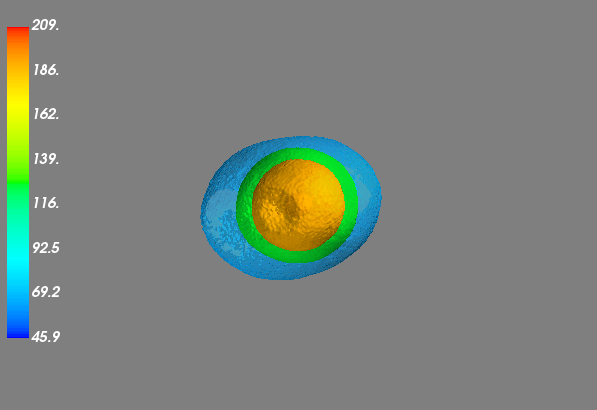

In [5]:
Image(filename='data/5a1a_projections_and_angles_predicted.png')